In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

import urllib.request as urlrq
import certifi
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#assert torch.cuda.is_available()

# Problem 1
Create the device variable.
Download the CIFAR10 training and test datasets.
Transform them into tensors and normalize them.

In [2]:
# Set device and transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,0.0,0.0),(1.0,1.0,1.0))])

# Download dataset
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('./test_data', train=False, download=True, transform=transform)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./test_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
           )


# Problem 2
Split the data into train, validation, and test sets, and create DataLoaders for each one. Use a batch size of 32 for the training set and 1 for the validation and test sets.

In [3]:
# Get data
actual_train_data = [train_data[i] for i in range(40_000)]
valid_data = [train_data[i] for i in range(40_000,50_000)]

# Get Loaders
train_loader = DataLoader(actual_train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Problem 3

Create a class for a convolutional neural network that accepts images as $3\times 32 \times 32$ tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.

The model should have at least three convolution layers, each followed by an activation function, a max pooling layer, and at least two linear layers.
Be sure that your final activation function is the softmax function.
Choose the size of the layers so that your model has at least 50,000 parameters, and record this calculation in the Jupyter notebook.

In [6]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set up Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=8, kernel_size=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=5, kernel_size=4, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=1280, out_features=100)
        self.unflatten1 = nn.Unflatten(1, torch.Size([2, 5, 5]))
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.linear2 = nn.Linear(in_features=100, out_features=10)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        
        # CNNs
        x_layer1 = self.relu(self.conv1(x))
        x_layer2 = self.relu(self.conv2(x_layer1))
        x_layer3 = self.relu(self.conv3(x_layer2))
        
        # Max Pool Layer
        x_layer4 = self.pool(x_layer3)
        
        # Linear Layers
        x_flat = self.flatten(x_layer4)
        x_layer6 = self.relu(self.linear1(x_flat))
        output = self.softmax(self.linear2(x_layer6))
        
        return output

In [7]:
model = MyCNN()

x = train_data[0][0].unsqueeze(0)

print(model.forward(x))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

tensor([[0.0973, 0.1059, 0.1019, 0.1006, 0.1029, 0.0980, 0.0905, 0.1109, 0.0978,
         0.0942]], grad_fn=<SoftmaxBackward>)
130123


C:\Users\bryan\anaconda3\envs\ss\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Problem 4
Send your model to the device and instantiate the objective and optimizer.
Train your model with a TQDM display, and calculate the Validation Accuracy after each epoch. 
Begin by initializing your TQDM loop, then for each epoch, do the following:

1. Set your model to training mode (model.train())
2. Instantiate an empty loss_list
3. For each batch in train_loader:
    - Send x and y_truth to device
    - Zero out the gradients 
    - Use model to predict labels of x
    - Calculate loss between predicted labels and y_truth
    - Append loss (loss.item()) to loss_list
    - Update TQDM loop 
    - Backpropagate to compute gradients 
    - Optimize and update the weights
4. Save the loss mean as the mean of the losses in loss_list
5. Set your model to evaluation mode (model.eval())
6. Calculate and save validation accuracy
Finish the training by closing your TQDM loop.

Train for 10 epochs, saving the mean loss and validation accuracy for each epoch.
Plot the mean losses and validation accuracies.

Finally, print the final test score.

In [10]:
def fit(model, train_loader, valid_loader, num_epochs=10):
    # Send to GPU
    model.to(device)
    
    # Instantiate Objective and Optimizer
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Set up progress bar
    loop = tqdm(total=len(train_loader), position=0)
    
    mean_losses, validation_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        loss_list = []
        
        # Iterate through batches in train_loader
        for x, y_truth in train_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = objective(y_hat, y_truth)
            loss_list.append(loss.item())
            loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss.item()))
            loop.update()
            loss.backward()
            optimizer.step()
            
        loss_mean = np.mean(loss_list)
        mean_losses.append(loss_mean)
        
        # Validation Loop
        model.eval()
        validation_score = 0
        for x, y_truth in valid_loader:
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            if y_truth == y_hat.argmax(1):
                validation_score += 1
        validation_accuracy = validation_score/len(valid_loader)
        validation_accuracies.append(validation_accuracy)

    loop.close()
    
    return model, mean_losses, validation_accuracies

In [11]:
model, means, validation_accuracies = fit(model, train_loader, valid_loader)

epoch:9, loss:2.1877: : 12500it [03:42, 56.11it/s]                                                                     


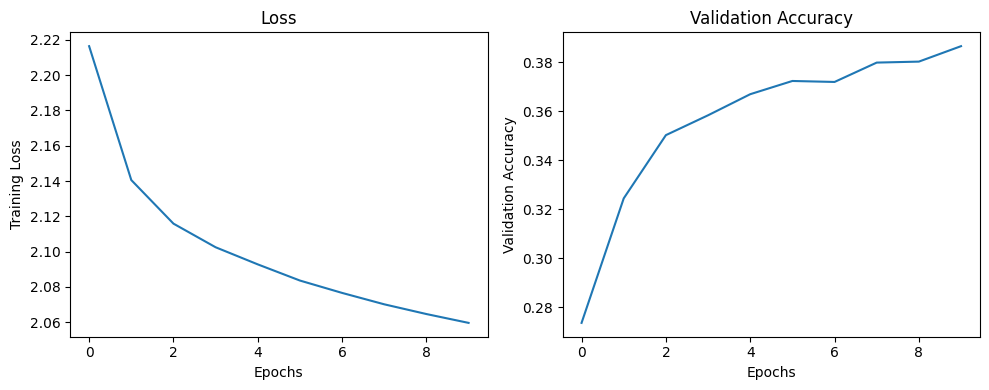

In [15]:
# Plot it
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(means)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss")

plt.subplot(122)
plt.plot(validation_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

In [8]:
model.eval()
test_score = 0
# Iterate through test set
for x, y_truth in test_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    
    # Predict and Score
    y_hat = model(x)
    if y_truth == y_hat.argmax(1):
        test_score += 1
        
print("Score:", test_score)
print("Accuracy:", test_score/10000)

Score: 3951
Accuracy: 0.3951


# Problem 5

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [4]:
# FGSM attack code
def fgsm_attack(model, optimizer, objective, x, y, eps):
    """
    Performs the FGSM attack on the given model and data point x with label y.
    Returns the perturbed data point.
    """
    model.to(device)
    
    # Calculate the gradient
    x.requires_grad = True
    x.retain_grad()
    optimizer.zero_grad()
    output = model(x)
    loss = objective(output, y)
    loss.backward()
    data_grad = x.grad.data
    # Perturb the images
    x_perturbed = x + eps * data_grad.sign()
    return x_perturbed

In [42]:
test_scores = []
# Iterate through epislons
for i, eps in enumerate([0,.05,.1,.15,.2,.25,.3]):
    test_score = 0
    # Go through test set
    for x,y_truth in test_loader:
        x,y_truth = x.to(device), y_truth.to(device)
        
        # Perturb
        x_perturbed = fgsm_attack(model, optim.Adam(model.parameters(), lr=1e-4), nn.CrossEntropyLoss(), x, y_truth, eps)
        
        # Predict
        y_hat = model(x_perturbed)
        
        # Score
        if y_truth == y_hat.argmax(1):
            test_score += 1
            
    test_scores.append(test_score/10000)

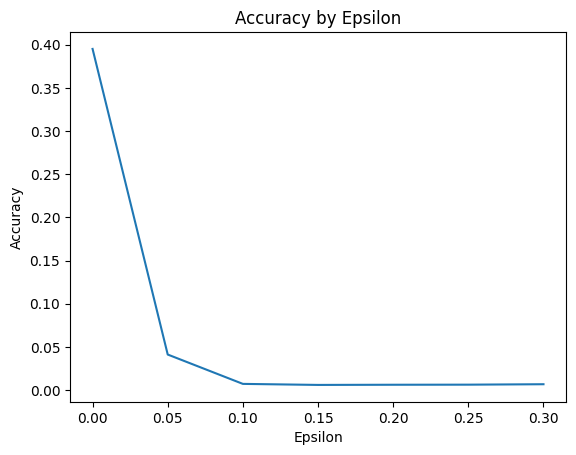

In [34]:
# Plot
epsilons = [0,.05,.1,.15,.2,.25,.3]
plt.plot(epsilons, test_scores)
plt.title("Accuracy by Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


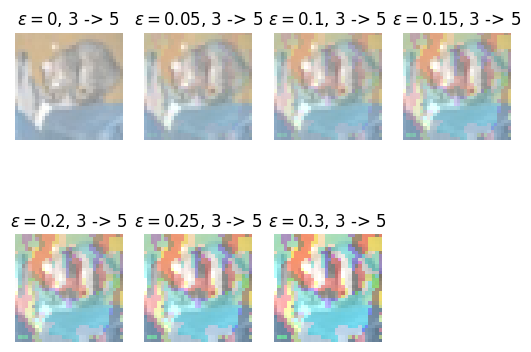

In [27]:
model.eval()
for i, eps in enumerate([0,.05,.1,.15,.2,.25,.3]):
    # Get only first image
    for x,y_truth in test_loader:
        x,y_truth = x.to(device), y_truth.to(device)
        break
    
    # Perturb
    x_perturbed = fgsm_attack(model, optim.Adam(model.parameters(), lr=1e-4), nn.CrossEntropyLoss(), x, y_truth, eps)
    ex = x_perturbed.squeeze().detach().cpu().numpy()
    img = ex/2 +.5
    
    # Plot
    plt.subplot(2,4,i+1)
    plt.title(f"$\epsilon={eps}$, {str(y_truth)[8]} -> {str(model(x).argmax(1))[8]}")
    plt.axis('off')
    plt.imshow(np.transpose(img, (1,2,0)))